In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_excel('data.xlsx')
df.columns

Index(['As_Of_Date', 'Position_amount', 'Total_account', 'Cash', 'ID'], dtype='object')

In [3]:
id_counts_per_date = df.groupby('As_Of_Date')['ID'].nunique()

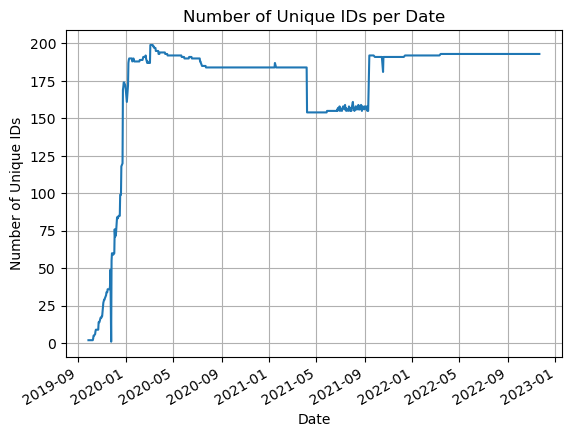

In [4]:
id_counts_per_date.plot()

plt.title('Number of Unique IDs per Date')
plt.xlabel('Date')
plt.grid()
plt.ylabel('Number of Unique IDs')
plt.show()

In [5]:
df = df.sort_values(by=['ID', 'As_Of_Date'])
df = df[df.groupby('ID')['Total_account'].cumsum() != 0]
df['daily_return'] = df.groupby('ID')['Total_account'].pct_change()
df['cumulative_total_return'] = (1 + df['daily_return']).groupby(df['ID']).cumprod() - 1

In [6]:
df = df.sort_values(by=['ID', 'As_Of_Date'])
df['running_max'] = df.groupby('ID')['cumulative_total_return'].cummax()
df['drawdown'] = (df['cumulative_total_return'] - df['running_max']) / (1 + df['running_max'])
df['max_drawdown'] = df.groupby('ID')['drawdown'].cummin()

In [7]:
df.to_csv('result.csv')

In [8]:
df['As_Of_Date'] = pd.to_datetime(df['As_Of_Date'])

In [9]:
def calculate_metrics(data, period=None):

    last_trade_day = data['As_Of_Date'].max()
    data = data[data['As_Of_Date'] <= last_trade_day]

    if period == 'month':
        data = data[data['As_Of_Date'] > last_trade_day - pd.DateOffset(months=1)]
    elif period == 'year':
        data = data[data['As_Of_Date'] > last_trade_day - pd.DateOffset(years=1)]

    # Calculate the duration between the first and last date
    date_range = data['As_Of_Date'].max() - data['As_Of_Date'].min()

    if period == 'month' and date_range.days < 20:
        return None
    elif period != 'month' and date_range.days < 250:
        return None

    annualized_return = data['daily_return'].mean() * 252
    annualized_volatility = data['daily_return'].std() * (252 ** 0.5)
    max_drawdown = data['max_drawdown'].iloc[-1]
    
    # If the annualized_volatility is zero, which means the cash in the account is inactive, setting sharpe_ratio to 1 as a flag
    if annualized_volatility == 0:
        sharpe_ratio = 1
    else:
        sharpe_ratio = annualized_return / annualized_volatility
    
    # If the maximum_drawdown is zero, which means the cash in the account is always increasing, setting calmar ratio to 1 as a flag
    if max_drawdown == 0:
        calmar_ratio = 1
    else:
        calmar_ratio = annualized_return / max_drawdown 
                    
    return pd.Series({
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'calmar_ratio': calmar_ratio,
        'max_drawdown':max_drawdown,

    })

# Find the last date
last_date = df['As_Of_Date'].max()

# Filter rows corresponding to the last date and extract the IDs
ids_on_last_day = df[df['As_Of_Date'] == last_date]['ID'].unique()


# 1 month 19043
metrics_month = df[df['ID'].isin(ids_on_last_day)].groupby('ID').apply(calculate_metrics, period='month')

# 1 year 19088
metrics_year = df[df['ID'].isin(ids_on_last_day)].groupby('ID').apply(calculate_metrics, period='year')

# Cumulative 19241
metrics_cumulative = df[df['ID'].isin(ids_on_last_day)].groupby('ID').apply(calculate_metrics)

In [10]:
metrics_month

annualized_return  annualized_volatility  sharpe_ratio  calmar_ratio  \
ID                                                                            
19001          -0.137433               0.374126     -0.367343      0.295726   
19002          -0.098250               0.347104     -0.283056      0.212718   
19003          -0.226079               0.263375     -0.858391      0.721384   
19004           0.239191               0.292175      0.818657     -0.572349   
19005          -0.100056               0.236498     -0.423073      0.237369   
...                  ...                    ...           ...           ...   
19235          -0.318732               0.144553     -2.204947      1.161378   
19236           0.506314               0.317101      1.596696     -1.961546   
19237           0.810724               0.234954      3.450570     -2.002186   
19238           1.784911               0.774641      2.304179     -2.613349   
19241           1.139082               0.235709      4.832584     -4.720742   

       max_drawdown  
ID                   
19001     -0.464729  
19002     -0.461878  
19003     -0.313396  
19004     -0.417912  
19005     -0.421521  
...             ...  
19235     -0.274443  
19236     -0.258120  
19237     -0.404919  
19238     -0.682997  
19241     -0.241293  

[193 rows x 5 columns]

In [11]:
metrics_year

annualized_return  annualized_volatility  sharpe_ratio  calmar_ratio  \
ID                                                                            
19001          -0.215906               0.243030     -0.888396      0.464586   
19002          -0.126428               0.214179     -0.590292      0.273726   
19003          -0.069502               0.224067     -0.310184      0.221770   
19004          -0.183549               0.223870     -0.819893      0.439205   
19005          -0.176288               0.202808     -0.869233      0.418218   
...                  ...                    ...           ...           ...   
19235          -0.114074               0.128218     -0.889686      0.415658   
19236          -0.102480               0.229402     -0.446727      0.397026   
19237          -0.183911               0.298646     -0.615816      0.454192   
19238          -0.215438               0.483162     -0.445891      0.315430   
19241           0.374174               0.292622      1.278695     -1.550703   

       max_drawdown  
ID                   
19001     -0.464729  
19002     -0.461878  
19003     -0.313396  
19004     -0.417912  
19005     -0.421521  
...             ...  
19235     -0.274443  
19236     -0.258120  
19237     -0.404919  
19238     -0.682997  
19241     -0.241293  

[193 rows x 5 columns]

In [12]:
metrics_cumulative

annualized_return  annualized_volatility  sharpe_ratio  calmar_ratio  \
ID                                                                            
19001           0.083797               0.262469      0.319263     -0.180313   
19002          -0.045593               0.221457     -0.205878      0.098712   
19003           0.009975               0.239239      0.041696     -0.031830   
19004           0.003592               0.230977      0.015553     -0.008596   
19005          -0.027352               0.229936     -0.118953      0.064888   
...                  ...                    ...           ...           ...   
19235          -0.138602               0.134185     -1.032917      0.505031   
19236          -0.080046               0.208723     -0.383503      0.310112   
19237          -0.216220               0.279965     -0.772311      0.533984   
19238           0.201363               0.602522      0.334200     -0.294822   
19241           0.374174               0.292622      1.278695     -1.550703   

       max_drawdown  
ID                   
19001     -0.464729  
19002     -0.461878  
19003     -0.313396  
19004     -0.417912  
19005     -0.421521  
...             ...  
19235     -0.274443  
19236     -0.258120  
19237     -0.404919  
19238     -0.682997  
19241     -0.241293  

[193 rows x 5 columns]

相关性及Beta计算

将每天每个用户的收益率平均值作为benchmark的收益率，计算净值，并计算5）中三个阶段最好用户和benchmark的相关性和beta

In [13]:
# Benchmark calculation

df['benchmark_return'] = df.groupby('As_Of_Date')['daily_return'].transform('mean')
mean_daily_returns = df.groupby('As_Of_Date')['daily_return'].mean()
mean_cumulative_returns = (1 + mean_daily_returns).cumprod() - 1
mean_cumulative_returns.name = 'benchmark_cumulative_return'
df = pd.merge(df, mean_cumulative_returns, on='As_Of_Date', how='left')

In [14]:
df.columns

Index(['As_Of_Date', 'Position_amount', 'Total_account', 'Cash', 'ID',
       'daily_return', 'cumulative_total_return', 'running_max', 'drawdown',
       'max_drawdown', 'benchmark_return', 'benchmark_cumulative_return'],
      dtype='object')

In [15]:
last_trade_day = df['As_Of_Date'].max()

# 1 month 19043
data = df[df['As_Of_Date'] > last_trade_day - pd.DateOffset(months=1)]
data = data[data['ID'] == 19043]
beta = np.polyfit(data['daily_return'], data['benchmark_return'], 1)[0]
correlations = df[df['ID'] == 19043]['daily_return'].corr(df['benchmark_return'])
print(f'beta is {beta:.4f}, correlation is {correlations:.4f}')

# 1 year 19088
data = df[df['As_Of_Date'] > last_trade_day - pd.DateOffset(years=1)]
data = data[data['ID'] == 19088]
beta = np.polyfit(data['daily_return'], data['benchmark_return'], 1)[0]
correlations = df[df['ID'] == 19088]['daily_return'].corr(df['benchmark_return'])
print(f'beta is {beta:.4f}, correlation is {correlations:.4f}')

# Cumulative 19241
data = df[df['ID'] == 19241]
data['daily_return'] = data['daily_return'].fillna(0)
beta = np.polyfit(data['daily_return'], data['benchmark_return'], 1)[0]
correlations = df[df['ID'] == 19241]['daily_return'].corr(df['benchmark_return'])
print(f'beta is {beta:.4f}, correlation is {correlations:.4f}')


beta is 0.4098, correlation is 0.7507
beta is 0.0849, correlation is 0.3295
beta is 0.5031, correlation is 0.7804


/var/folders/n_/qw7pwss90l9b2pz6w26kgpj00000gn/T/ipykernel_31403/315738984.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['daily_return'] = data['daily_return'].fillna(0)


In [16]:
beta, correlations

(0.5031211908504432, 0.7804183154025838)

In [17]:
split_date = df['As_Of_Date'].quantile(0.95)
df_95 = df[df['As_Of_Date'] <= split_date]
df_5 = df[df['As_Of_Date'] > split_date]
date = df['As_Of_Date'].max()
print(f'the last day of first 95%: {split_date}')
print(f'the last day: {date}')


def calculate_calmar_ratio(data, response: False):

    if response:
        data = data[data['As_Of_Date'] >= last_trade_day]
        data = data.sort_values(by='As_Of_Date')
        data['running_max'] = data['cumulative_total_return'].cummax()
        data['drawdown'] = (data['cumulative_total_return'] - df['running_max']) / (1 + df['running_max'])
        data['max_drawdown'] = data['drawdown'].cummin()
        
    else:
        data = data[data['As_Of_Date'] < last_trade_day]
    
    annualized_return = data['daily_return'].mean() * 252
    max_drawdown = data['max_drawdown'].iloc[-1]
    # If the maximum_drawdown is zero, which means the cash in the account is always increasing, setting calmar ratio to 1 as a flag
    if max_drawdown == 0:
        calmar_ratio = 1
    else:
        calmar_ratio = annualized_return / max_drawdown 
        

    return calmar_ratio

ids_on_split_day = df[df['As_Of_Date'] == split_date]['ID'].unique()


for i, unique_id in enumerate(ids_on_split_day):
    df_temp = df[df['ID'] == unique_id]
    
    # Calculate for both conditions (response True and False)
    calmar_before_split = calculate_calmar_ratio(df_temp, response=False)
    calmar_after_split = calculate_calmar_ratio(df_temp, response=True)
    new_data = [unique_id, calmar_before_split, calmar_after_split]

    if i == 0:
        result_df = pd.DataFrame({
        'ID': [unique_id],
        'Calmar_Before_Split': [calmar_before_split],
        'Calmar_After_Split': [calmar_after_split]})
    else:
        result_df.loc[len(result_df)] = new_data


the last day of first 95%: 2022-09-27 00:00:00
the last day: 2022-11-21 00:00:00


In [18]:
import statsmodels.api as sm
X = result_df['Calmar_Before_Split'].values.reshape(-1, 1)
y = result_df['Calmar_After_Split'].values.reshape(-1, 1)

x = sm.add_constant(X)
model = sm.OLS(y, x).fit()

t_statistic = model.tvalues[1]  
p_value = model.pvalues[1]      


print(t_statistic)
print(p_value)


0.9429205307445325
0.3469126986147065
